As discussões sobre os scores estão no pacote `proper_scoring_rules`. 

Implementação: 
* CRPS
* Log Score
* MAE
* Interval Score;

Acho a ideia da **janela deslizante** uma boa.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product 
import matplotlib.pyplot as plt
from mosqlient import get_predictions
from mosqlient.datastore import Infodengue
from scoringrules import crps_normal, logs_normal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def transform_json_to_dataframe(res:dict) -> pd.DataFrame:

    json_struct = json.loads(res['prediction'])    
    df = pd.json_normalize(json_struct)
    df.dates = pd.to_datetime(df.dates)

    return df

    

In [3]:
def interval_score(l, u, y, alpha):
    """
    Calculate the interval score for given prediction intervals and observed values.

    Parameters:
    l (array-like): Lower bounds of the prediction intervals.
    u (array-like): Upper bounds of the prediction intervals.
    y (array-like): Observed values.
    alpha (float): Significance level (e.g., 0.05 for a 95% prediction interval).

    Returns:
    array: The interval scores for each prediction interval and observed value.
    """
    l = np.array(l)
    u = np.array(u)
    y = np.array(y)
    
    # Width of the prediction intervals
    interval_width = u - l

    # Penalty for the observed values falling below the lower bounds
    penalty_below = (2 / alpha) * (l - y) * (y < l)

    # Penalty for the observed values exceeding the upper bounds
    penalty_above = (2 / alpha) * (y - u) * (y > u)

    # Total interval scores
    scores = interval_width + penalty_below + penalty_above

    return scores

In [4]:
df1 = transform_json_to_dataframe(get_predictions(id = 78))

df2 = transform_json_to_dataframe(get_predictions(id = 77))

In [5]:
from datetime import timedelta

In [6]:
min_dates = max(min(df1.dates), min(df2.dates))
max_dates = min(max(df1.dates), max(df2.dates))

min_dates.strftime("%Y-%m-%d")

'2022-01-02'

In [7]:
max_dates.strftime("%Y-%m-%d")

'2023-06-25'

In [8]:
df1 = df1.loc[ (df1.dates >= min_dates) & (df1.dates<= max_dates)]

df2 = df2.loc[ (df2.dates >= min_dates) & (df2.dates<= max_dates)]

In [9]:
df2.tail()

,dates,preds,lower,upper,adm_2,adm_1,adm_0
73,2023-05-28,1134.07,343.094835,1925.045165,3304557,RJ,BR
74,2023-06-04,2243.41,1319.517106,3167.302894,3304557,RJ,BR
75,2023-06-11,2239.65,1112.819877,3366.480123,3304557,RJ,BR
76,2023-06-18,1068.35,0.000000,2215.129540,3304557,RJ,BR
77,2023-06-25,624.00,0.000000,1599.324556,3304557,RJ,BR


In [10]:
df1.columns

Index(['dates', 'preds', 'lower', 'upper', 'adm_2', 'adm_1', 'adm_0'], dtype='object')

In [11]:
type(df1.adm_2.values[0])

numpy.int64

In [12]:
df1.adm_2.values[0]

3304557

In [18]:
data = Infodengue.get(per_page =  100,
    disease =  "dengue",
    start = min_dates.strftime("%Y-%m-%d"),
    end = max_dates.strftime("%Y-%m-%d"),  
    geocode = 3304557)

type(data)

list

In [15]:
len(data)

78

In [19]:
data = Infodengue.get(per_page =  100,
    disease =  "dengue",
    start = min_dates.strftime("%Y-%m-%d"),
    end = max_dates.strftime("%Y-%m-%d"),  
    geocode = 3304557)

data = pd.DataFrame(data)
data.data_iniSE = pd.to_datetime(data.data_iniSE)

data

,data_iniSE,SE,casos_est,casos_est_min,casos_est_max,casos,municipio_geocodigo,p_rt1,p_inc100k,Localidade_id,...,nivel_inc,umidmed,umidmin,tempmed,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf
0,2023-06-25,202326,996.0,996,996,996,3304557,4.794721e-09,15.032036,0,...,2,77.834886,54.162971,21.416771,26.901100,497.0,None,None,None,None
1,2023-06-18,202325,1236.0,1236,1236,1236,3304557,1.168667e-01,18.654213,0,...,2,75.622357,53.692829,19.861314,24.833357,702.0,None,None,None,None
2,2023-06-11,202324,1348.0,1348,1348,1348,3304557,3.959262e-01,20.344563,0,...,2,82.430443,64.658500,22.452714,26.168286,782.0,None,None,None,None
3,2023-06-04,202323,1238.0,1238,1238,1238,3304557,1.961739e-07,18.684399,0,...,2,79.784100,54.306371,20.479629,26.337529,737.0,None,None,None,None
4,2023-05-28,202322,1328.0,1328,1328,1328,3304557,2.454523e-10,20.042715,0,...,2,88.264806,87.689309,20.283333,20.500000,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2022-01-30,202205,31.0,31,31,31,3304557,9.479307e-01,0.459408,0,...,0,82.047129,62.021037,26.560596,31.285714,NaN,None,None,None,None
74,2022-01-23,202204,19.0,19,19,19,3304557,6.156365e-01,0.281573,0,...,0,69.429899,51.174419,28.130952,32.428571,NaN,None,None,None,None
75,2022-01-16,202203,22.0,22,22,22,3304557,9.071423e-01,0.326031,0,...,0,75.738139,58.251960,27.729342,31.857143,NaN,None,None,None,None
76,2022-01-09,202202,14.0,14,14,14,3304557,8.675266e-01,0.207475,0,...,0,85.374822,67.319631,25.154762,28.571429,NaN,None,None,None,None


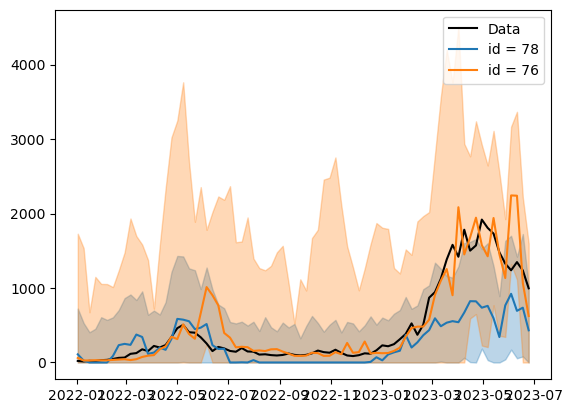

In [20]:
fig,ax = plt.subplots()

ax.plot(data.data_iniSE, data.casos, color = 'black', label = 'Data')

ax.plot(df1.dates, df1.preds, color = 'tab:blue', label = 'id = 78')

ax.fill_between(df1.dates, df1.lower, df1.upper, color = 'tab:blue', alpha = 0.3)

ax.plot(df2.dates, df2.preds, color = 'tab:orange', label = 'id = 76')

ax.fill_between(df2.dates, df2.lower, df2.upper, color = 'tab:orange', alpha = 0.3)

ax.legend()

plt.show()

In [15]:
def comp_interval(data, df_preds):

    return np.mean(interval_score(l = df_preds.lower, u = df_preds.upper, y = data.casos, alpha = 0.05))
    

In [19]:

def evaluate_point_metrics(y_true, y_pred, metric):
    """
    Evaluate multiple sklearn metrics on given true and predicted values.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.
    metrics (str): Options: ['MAE', 'MSE'] .

    Returns:
    Scores.
    """

    if metric == 'MAE':

        m = mean_absolute_error

    if metric == 'MSE':
        
        m = mean_squared_error
    
    score = m(y_true, y_pred)
        
    return score

~Modelo Baseline;~

Possibilidades: 

- ids, mais de um id 
- ys, mais de uma previsão
- id e y

Para o log score e crps retornar a curva ou a média/soma? Retornar 

Testes de algumas visualizações, mas quando a escala das previsões é muito diferente não sei o quão útil elas são. 

In [ ]:
score(ids = [30, 23], ys = [minhas_previsões])

Class Scorer

def init():

    self.ids = ids 
    self.ys = ys 
    
    property da class para o cálculo dos scores; 



In [31]:
def summary_scores(ids, y, geocode, metrics, start_date = None, end_date = None):

    # Tem que adiconar o código para conferir se as predictions se referem ao mesmo geocode

    dfs = {}

    scores = {}

    min_dates = []
    max_dates = []

    for id_ in ids: 

        scores[id_] = {}
        
        df = transform_json_to_dataframe(get_predictions(id = id_))

        df.dates = pd.to_datetime(df.dates)
        
        min_dates.append(min(df.dates))
        max_dates.append(max(df.dates))

        dfs[id_] = df

    #min_dates.append(min(y.dates))
    #max_dates.append(max(y.dates))

    min_date = max(min_dates)
    max_date = min(max_dates)

    for id_ in ids: 

        df = dfs[id_]
        df = df.loc[ (df.dates >= min_date) & (df.dates<= max_date)]

        dfs[id_] = df

    data = Infodengue.get(per_page =  100,
    disease =  "dengue",
    start = min_date.strftime("%Y-%m-%d"),
    end = max_date.strftime("%Y-%m-%d"),  
    geocode = geocode)

    data.data_iniSE = pd.to_datetime(data.data_iniSE)

    data = data.sort_values(by = 'data_iniSE')

    
    

    for (id_, m) in product(ids, metrics):

        df = dfs[id_]

        if m == 'CRPS': 

            scores[id_][m] = np.mean(crps_normal(data.casos, df.preds, (df.upper-df.lower)/4))

        elif m == 'log_score': 

            scores[id_][m] = np.mean(logs_normal(data.casos, df.preds, (df.upper-df.lower)/4))

        elif m == 'interval_score': 

            scores[id_][m] = comp_interval(data, df)
            
        else: 
            scores[id_][m] = evaluate_point_metrics(y_true = data.casos,
                       y_pred = df.preds,
                       metric = m)

    df_scores =  pd.DataFrame.from_dict(scores, orient='index')

    df_scores.index.name = 'id'

    return df_scores


    

    

In [54]:
def curve_scores(ids, y, geocode, metrics, start_date = None, end_date = None):

    # Tem que adiconar o código para conferir se as predictions se referem ao mesmo geocode

    dfs = {}

    scores = {}

    min_dates = []
    max_dates = []

    for id_ in ids: 

        scores[id_] = {}
        
        df = transform_json_to_dataframe(get_predictions(id = id_))

        df.dates = pd.to_datetime(df.dates)
        
        min_dates.append(min(df.dates))
        max_dates.append(max(df.dates))

        dfs[id_] = df

    #min_dates.append(min(y.dates))
    #max_dates.append(max(y.dates))

    min_date = max(min_dates)
    max_date = min(max_dates)

    for id_ in ids: 

        df = dfs[id_]
        df = df.loc[ (df.dates >= min_date) & (df.dates<= max_date)]

        dfs[id_] = df

    data = Infodengue.get(per_page =  100,
    disease =  "dengue",
    start = min_date.strftime("%Y-%m-%d"),
    end = max_date.strftime("%Y-%m-%d"),  
    geocode = geocode)

    data.data_iniSE = pd.to_datetime(data.data_iniSE)

    data = data.sort_values(by = 'data_iniSE')
    

    for (id_, m) in product(ids, metrics):

        df = dfs[id_]

        if m == 'CRPS': 

            scores[id_][m] = crps_normal(data.casos, df.preds, (df.upper-df.lower)/4)

        elif m == 'log_score': 

            scores[id_][m] = logs_normal(data.casos, df.preds, (df.upper-df.lower)/4)

        elif m == 'interval_score': 

            scores[id_][m] = comp_interval(data, df)
        

    return scores, data

In [56]:
sc, data = curve_scores(ids = [78,77], y = None, geocode = 3304557, metrics = ['CRPS'])

sc

{78: {'CRPS': array([  59.17210702,   31.32624838,   25.62051849,   27.72182718,
           38.02723199,   36.79378887,   39.49623517,  102.55033965,
          109.38720992,   78.14419569,  154.81989669,   99.74842776,
           40.86510719,   58.42181733,   37.64039692,   55.27388931,
           71.74325388,  100.68909924,   88.21350721,  100.8468347 ,
           75.32568113,   84.18628768,  155.64524938,   67.35687595,
           47.00397815,   42.5787832 ,   95.54291183,   88.08683267,
          124.45432512,   92.15949787,   67.31492606,   63.88916486,
           65.96655536,   58.89596409,   56.04361389,   60.32009221,
           72.49969988,   60.75336065,   58.87652741,   60.68067774,
           73.26342152,   99.88701729,   89.22985872,   79.31257287,
          106.50114926,   81.70174562,   56.71668634,   52.36230557,
           58.60689776,   73.96927018,   65.72062486,   55.64540068,
          128.80760406,   65.8055892 ,   66.65761594,   91.93513813,
           51.65336606

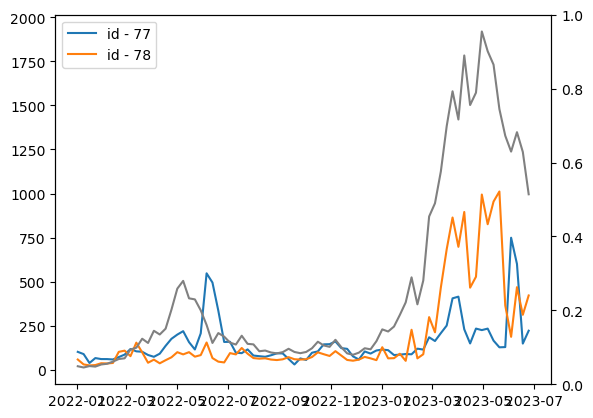

In [66]:
fig, ax = plt.subplots()

ax.plot(data.data_iniSE, sc[77]['CRPS'], label = 'id - 77')

ax.plot(data.data_iniSE, sc[78]['CRPS'], label = 'id - 78')

ax.legend()


ax2 = ax.twinx()

ax.plot(data.data_iniSE, data.casos, label = 'Data', color = 'grey')

plt.show()


In [52]:
pd.DataFrame.from_dict(sc, orient='index').loc[78, 'CRPS']

array([  59.17210702,   31.32624838,   25.62051849,   27.72182718,
         38.02723199,   36.79378887,   39.49623517,  102.55033965,
        109.38720992,   78.14419569,  154.81989669,   99.74842776,
         40.86510719,   58.42181733,   37.64039692,   55.27388931,
         71.74325388,  100.68909924,   88.21350721,  100.8468347 ,
         75.32568113,   84.18628768,  155.64524938,   67.35687595,
         47.00397815,   42.5787832 ,   95.54291183,   88.08683267,
        124.45432512,   92.15949787,   67.31492606,   63.88916486,
         65.96655536,   58.89596409,   56.04361389,   60.32009221,
         72.49969988,   60.75336065,   58.87652741,   60.68067774,
         73.26342152,   99.88701729,   89.22985872,   79.31257287,
        106.50114926,   81.70174562,   56.71668634,   52.36230557,
         58.60689776,   73.96927018,   65.72062486,   55.64540068,
        128.80760406,   65.8055892 ,   66.65761594,   91.93513813,
         51.65336606,  227.85349054,   65.7101885 ,   88.89014

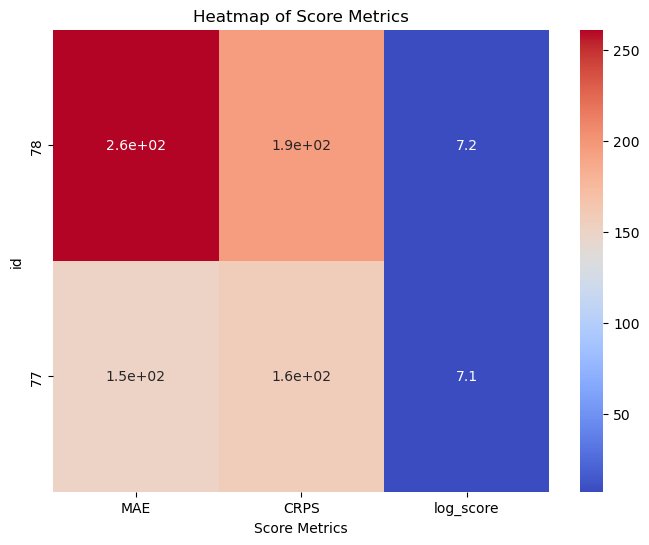

In [39]:
# Plot heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.heatmap(sc[['MAE', 'CRPS', 'log_score']], annot=True, cmap='coolwarm', cbar=True)

# Add labels and title
plt.title('Heatmap of Score Metrics')
plt.xlabel('Score Metrics')
plt.ylabel('id')

# Show plot
plt.show()

In [30]:

df

,MAE,MSE,CRPS,log_score,interval_score
id,,,,,
78,260.983184,166280.634997,194.826199,7.206595,2171.979336
77,150.218462,69988.363187,156.069647,7.138349,1951.455378
